In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


In [ ]:
# Reading the data
df = pd.read_csv("/content/spam.csv",encoding='latin-1')
df.head()


,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [ ]:
df = df.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1)
df = df.rename(columns={'v1':'label','v2':'Text'})
df['label_enc'] = df['label'].map({'ham':0,'spam':1})
df.head()


,label,Text,label_enc
0,ham,"Go until jurong point, crazy.. Available only ...",0
1,ham,Ok lar... Joking wif u oni...,0
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,1
3,ham,U dun say so early hor... U c already then say...,0
4,ham,"Nah I don't think he goes to usf, he lives aro...",0


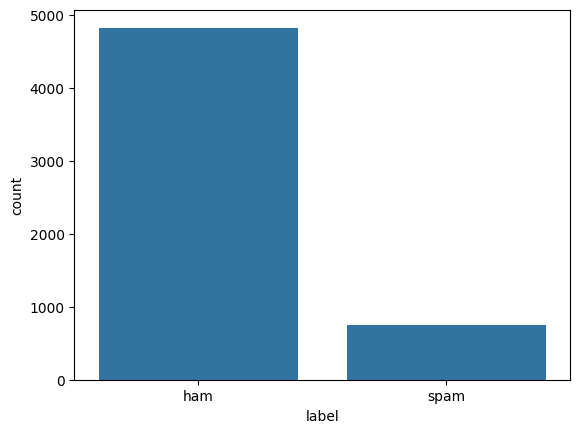

In [ ]:
sns.countplot(x=df['label'])
plt.show()


In [ ]:
# Find average number of tokens in all sentences
avg_words_len=round(sum([len(i.split()) for i in df['Text']])/len(df['Text']))
print(avg_words_len)


15


In [ ]:
s = set()
for sent in df['Text']:
    for word in sent.split():
        s.add(word)
total_words_length = len(s)
print(total_words_length)


15585


In [ ]:
# Splitting data for Training and testing
from sklearn.model_selection import train_test_split

X, y = np.asanyarray(df['Text']), np.asanyarray(df['label_enc'])
new_df = pd.DataFrame({'Text': X, 'label': y})
X_train, X_test, y_train, y_test = train_test_split(
	new_df['Text'], new_df['label'], test_size=0.2, random_state=42)
X_train.shape, y_train.shape, X_test.shape, y_test.shape


((4457,), (4457,), (1115,), (1115,))

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report,accuracy_score

tfidf_vec = TfidfVectorizer().fit(X_train)
X_train_vec,X_test_vec = tfidf_vec.transform(X_train),tfidf_vec.transform(X_test)

baseline_model = MultinomialNB()
baseline_model.fit(X_train_vec,y_train)


MultinomialNB()

In [ ]:
from tensorflow.keras.layers import TextVectorization

MAXTOKENS=total_words_length
OUTPUTLEN=avg_words_len

text_vec = TextVectorization(
	max_tokens=MAXTOKENS,
	standardize='lower_and_strip_punctuation',
	output_mode='int',
	output_sequence_length=OUTPUTLEN
)
text_vec.adapt(X_train)


In [ ]:
embedding_layer = layers.Embedding(
	input_dim=MAXTOKENS,
	output_dim=128,
	embeddings_initializer='uniform',
	input_length=OUTPUTLEN
)


In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
x = layers.GlobalAveragePooling1D()(embedding_layer_model)
x = layers.Flatten()(x)
x = layers.Dense(32, activation='relu')(x)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_1 = keras.Model(input_layer, output_layer)

model_1.compile(optimizer='adam', loss=keras.losses.BinaryCrossentropy(
	label_smoothing=0.5), metrics=['accuracy'])


In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score

def compile_model(model):
	'''
	simply compile the model with adam optimzer
	'''
	model.compile(optimizer=keras.optimizers.Adam(),
				loss=keras.losses.BinaryCrossentropy(),
				metrics=['accuracy'])

def fit_model(model, epochs, X_train=X_train, y_train=y_train,
			X_test=X_test, y_test=y_test):
	'''
	fit the model with given epochs, train
	and test data
	'''
	history = model.fit(X_train,
						y_train,
						epochs=epochs,
						validation_data=(X_test, y_test),
						validation_steps=int(0.2*len(X_test)))
	return history

def evaluate_model(model, X, y):
	'''
	evaluate the model and returns accuracy,
	precision, recall and f1-score
	'''
	y_preds = np.round(model.predict(X))
	accuracy = accuracy_score(y, y_preds)
	precision = precision_score(y, y_preds)
	recall = recall_score(y, y_preds)
	f1 = f1_score(y, y_preds)

	model_results_dict = {'accuracy': accuracy,
						'precision': precision,
						'recall': recall,
						'f1-score': f1}

	return model_results_dict


In [ ]:
input_layer = layers.Input(shape=(1,), dtype=tf.string)
vec_layer = text_vec(input_layer)
embedding_layer_model = embedding_layer(vec_layer)
bi_lstm = layers.Bidirectional(layers.LSTM(
	64, activation='tanh', return_sequences=True))(embedding_layer_model)
lstm = layers.Bidirectional(layers.LSTM(64))(bi_lstm)
flatten = layers.Flatten()(lstm)
dropout = layers.Dropout(.1)(flatten)
x = layers.Dense(32, activation='relu')(dropout)
output_layer = layers.Dense(1, activation='sigmoid')(x)
model_2 = keras.Model(input_layer, output_layer)

compile_model(model_2) # compile the model
history_2 = fit_model(model_2, epochs=5) # fit the model


Epoch 1/5
140/140 [==============================] - 34s 116ms/step - loss: 0.1676 - accuracy: 0.9439 - val_loss: 0.0869 - val_accuracy: 0.9776
Epoch 2/5
140/140 [==============================] - 13s 94ms/step - loss: 0.0256 - accuracy: 0.9933 - val_loss: 0.0954 - val_accuracy: 0.9749
Epoch 3/5
140/140 [==============================] - 13s 92ms/step - loss: 0.0071 - accuracy: 0.9989 - val_loss: 0.1903 - val_accuracy: 0.9623
Epoch 4/5
140/140 [==============================] - 13s 96ms/step - loss: 0.0025 - accuracy: 0.9993 - val_loss: 0.1386 - val_accuracy: 0.9695
Epoch 5/5
140/140 [==============================] - 13s 91ms/step - loss: 1.9431e-04 - accuracy: 1.0000 - val_loss: 0.1585 - val_accuracy: 0.9749


In [ ]:
import tensorflow_hub as hub

# model with Sequential api
model_3 = keras.Sequential()

# universal-sentence-encoder layer
# directly from tfhub
use_layer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
						trainable=False,
						input_shape=[],
						dtype=tf.string,
						name='USE')
model_3.add(use_layer)
model_3.add(layers.Dropout(0.2))
model_3.add(layers.Dense(64, activation=keras.activations.relu))
model_3.add(layers.Dense(1, activation=keras.activations.sigmoid))

compile_model(model_3)

history_3 = fit_model(model_3, epochs=5)


Epoch 1/5
140/140 [==============================] - 7s 25ms/step - loss: 0.3119 - accuracy: 0.9195 - val_loss: 0.1194 - val_accuracy: 0.9677
Epoch 2/5
140/140 [==============================] - 3s 22ms/step - loss: 0.0840 - accuracy: 0.9778 - val_loss: 0.0737 - val_accuracy: 0.9758
Epoch 3/5
140/140 [==============================] - 3s 22ms/step - loss: 0.0580 - accuracy: 0.9827 - val_loss: 0.0610 - val_accuracy: 0.9767
Epoch 4/5
140/140 [==============================] - 4s 29ms/step - loss: 0.0492 - accuracy: 0.9847 - val_loss: 0.0546 - val_accuracy: 0.9812
Epoch 5/5
140/140 [==============================] - 3s 22ms/step - loss: 0.0409 - accuracy: 0.9879 - val_loss: 0.0519 - val_accuracy: 0.9812


In [ ]:
baseline_model_results = evaluate_model(baseline_model, X_test_vec, y_test)
model_1_results = evaluate_model(model_1, X_test, y_test)
model_2_results = evaluate_model(model_2, X_test, y_test)
model_3_results = evaluate_model(model_3, X_test, y_test)

total_results = pd.DataFrame({'MultinomialNB Model':baseline_model_results,
							'Custom-Vec-Embedding Model':model_1_results,
							'Bidirectional-LSTM Model':model_2_results,
							'USE-Transfer learning Model':model_3_results}).transpose()

total_results


35/35 [==============================] - 1s 20ms/step


,accuracy,precision,recall,f1-score
MultinomialNB Model,0.962332,1.000000,0.720000,0.837209
Custom-Vec-Embedding Model,0.212556,0.111940,0.700000,0.193015
Bidirectional-LSTM Model,0.974888,0.923611,0.886667,0.904762
USE-Transfer learning Model,0.981166,0.944828,0.913333,0.928814
